In [ ]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

1.13.0+cu116


In [ ]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assigning to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=1.13.0+cu116
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [ ]:
import torch
import torch_geometric
import typing
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt


from torch_geometric.nn import GATConv, GraphConv, JumpingKnowledge
from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


In [ ]:
class JKGAT(nn.Module):
    """ 
    Graph Attention Network as in Velickovic et al. 2018 with the option to 
    drop attention and/or add a jumping knowledge connection.

    """

    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, output_dim, 
                 dropout, attention=True, jk=False):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        self.jk = None

        if attention and jk: # => 
            first_layer = GATConv(self.input_dim, self.hidden_dim, 
                                  self.n_heads, concat = True, 
                                  dropout = self.dropout, aggr = 'add')
            hidden_layers = [GATConv(self.hidden_dim*self.n_heads, self.hidden_dim, 
                                     self.n_heads, concat = True, 
                                     dropout = self.dropout, aggr = 'add')]*(n_layers-2)
            output_layer = GATConv(self.hidden_dim*self.n_heads, self.hidden_dim,
                                   self.n_heads, concat = True,
                                   dropout = self.dropout, aggr = 'add')
            self.jk = JumpingKnowledge("lstm", self.hidden_dim*self.n_heads, self.n_layers)
            self.lin = nn.Linear(self.hidden_dim*self.n_heads, self.output_dim)
        elif attention: #and not jk
            first_layer = GATConv(self.input_dim, self.hidden_dim, 
                                  self.n_heads, concat = True, 
                                  dropout = self.dropout, aggr = 'add')
            hidden_layers = [GATConv(self.hidden_dim*self.n_heads, self.hidden_dim, 
                                     self.n_heads, concat = True, 
                                     dropout = self.dropout, aggr = 'add')]*(n_layers-2)
            output_layer = GATConv(self.hidden_dim*self.n_heads, self.output_dim, 
                                   heads = 1, concat = True, 
                                   dropout = self.dropout, aggr = 'add')
        elif jk: #and not attention
            first_layer = GraphConv(self.input_dim, self.hidden_dim)
            hidden_layers = [GraphConv(self.hidden_dim, self.hidden_dim)]*(n_layers-2)
            output_layer = GraphConv(self.hidden_dim, self.hidden_dim)
            self.jk = JumpingKnowledge("lstm", self.hidden_dim, self.n_layers)
            self.lin = nn.Linear(self.hidden_dim, self.output_dim)
        else: #no jk nor attention
            first_layer = GraphConv(self.input_dim, self.hidden_dim)
            hidden_layers = [GraphConv(self.hidden_dim, self.hidden_dim)]*(n_layers-2)
            output_layer = GraphConv(self.hidden_dim, self.output_dim)

        self.layers = nn.ModuleList([first_layer] + hidden_layers)
        self.output_layer = output_layer

    def forward(self, x, edge_index):
        """
        Returns the node representations
        """
        xs = []
        #first n-1 layers
        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if self.jk is not None:
                xs.append(x)
        
        #final layer, retrieving attention weights if chosen
        if self.attention:
            x, attention = self.output_layer(x, edge_index, return_attention_weights=True)
        else:
            x = self.output_layer(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)
        if self.jk is not None:
            xs.append(x)

        #performing jumping knowledge connection if chosen
        if self.jk is not None:
            x = self.jk(xs)
            x = self.lin(x)

        return x

    def param_init(self):
        for layer in self.layers:
            layer.reset_parameters()
        self.output_layer.reset_parameters()


In [ ]:
def train(params: typing.Dict) -> torch.nn.Module:
    """ Trains node classification model and returns the trained model """
    #set device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    #load dataset
    data = dataset.data
    data = data.to(device)

    #update parameters
    params["input_dim"] = dataset.num_features 
    params["output_dim"] = dataset.num_classes

    #set model
    if params["model_name"] == 'JKGAT':
        model = JKGAT(
            params["input_dim"], 
            params["hidden_dim"], 
            params["n_layers"],
            params["n_heads"], 
            params["output_dim"],
            params["dropout"],
            params["attention"],
            params["jk"]
        ).to(device)
    elif params["model_name"] == 'SkipJKGAT':
        model = SkipJKGAT(
            params["input_dim"], 
            params["hidden_dim"], 
            params["n_layers"],
            params["n_heads"], 
            params["output_dim"],
            params["dropout"],
            params["attention"],
            params["jk"]
        ).to(device)

    #initialise parameters
    model.param_init()

    #loss and optimizer initialisation
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=params["lr"], 
                                 weight_decay=params["weight_decay"])
    num_epochs = params["epochs"]
    patience = params["max_patience"]

    val_accs = []

    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()

        x = data.x
        edge_index = data.edge_index
        y = data.y
        train_mask = data.train_mask
        val_mask = data.val_mask

        #retrieving node representations
        outputs = model(x, edge_index)

        loss = criterion(outputs[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()

        val_acc = evaluate(model, data, val_mask)
        val_accs.append(val_acc)

        #early stopping
        if epoch >= patience:
            last_k = val_accs[-patience:]
            if all(earlier >= later for earlier, later in zip(last_k, last_k[1:])):
                break

    print('Early stopped at epoch', epoch+1)
    print('Best validation accuracy:', max(val_accs))
    return model


In [ ]:
def evaluate(model, data, mask):
    x = data.x
    edge_index = data.edge_index
    y = data.y

    model.eval()
    outputs = model(x, edge_index)
    pred = torch.argmax(outputs[mask], 1)

    acc = torch.sum(torch.eq(y[mask], pred)) / y[mask].size()[0]

    return acc

In [ ]:
jk_a_params = {
    "hidden_dim":8, 
    "n_layers":2,
    "n_heads":8, 
    "dropout":0.6,
    "attention":True,
    "jk":True,
    "lr":0.005,
    "weight_decay":0.0005,
    "epochs":500,
    "max_patience":10,
    "model_name":"JKGAT"
}

jk_params = {
    "hidden_dim":8, 
    "n_layers":2,
    "n_heads":8, 
    "dropout":0.6,
    "attention":False,
    "jk":True,
    "lr":0.005,
    "weight_decay":0.0005,
    "epochs":500,
    "max_patience":10,
    "model_name":"JKGAT"
}

a_params = {
    "hidden_dim":8, 
    "n_layers":2,
    "n_heads":8, 
    "dropout":0.6,
    "attention":True,
    "jk":False,
    "lr":0.005,
    "weight_decay":0.0005,
    "epochs":500,
    "max_patience":10,
    "model_name":"JKGAT"
}

params = {
    "hidden_dim":8, 
    "n_layers":2,
    "n_heads":8, 
    "dropout":0.6,
    "attention":False,
    "jk":False,
    "lr":0.005,
    "weight_decay":0.0005,
    "epochs":500,
    "max_patience":10,
    "model_name":"JKGAT"
}

In [ ]:
torch.manual_seed(123) # set seed

In [ ]:
noskip_jk_a_2_layer = train(jk_a_params)

Early stopped at epoch 174
Best validation accuracy: tensor(0.7980, device='cuda:0')


In [ ]:
noskip_jk_2_layer = train(jk_params)

Early stopped at epoch 106
Best validation accuracy: tensor(0.7340, device='cuda:0')


In [ ]:
noskip_a_2_layer = train(a_params)

Early stopped at epoch 38
Best validation accuracy: tensor(0.8100, device='cuda:0')


In [ ]:
noskip_base_2_layer = train(params)

Early stopped at epoch 68
Best validation accuracy: tensor(0.7420, device='cuda:0')


In [ ]:
jk_a_params["n_layers"] = 3
jk_params["n_layers"] = 3
a_params["n_layers"] = 3
params["n_layers"] = 3

In [ ]:
noskip_jk_a_3_layer = train(jk_a_params)

Early stopped at epoch 36
Best validation accuracy: tensor(0.8160, device='cuda:0')


In [ ]:
noskip_jk_3_layer = train(jk_params)

Early stopped at epoch 172
Best validation accuracy: tensor(0.6760, device='cuda:0')


In [ ]:
noskip_a_3_layer = train(a_params)

Early stopped at epoch 141
Best validation accuracy: tensor(0.8080, device='cuda:0')


In [ ]:
noskip_base_3_layer = train(params)

Early stopped at epoch 222
Best validation accuracy: tensor(0.7500, device='cuda:0')


In [ ]:
jk_a_params["n_layers"] = 4
jk_params["n_layers"] = 4
a_params["n_layers"] = 4
params["n_layers"] = 4

In [ ]:
noskip_jk_a_4_layer = train(jk_a_params)

Early stopped at epoch 250
Best validation accuracy: tensor(0.7780, device='cuda:0')


In [ ]:
noskip_jk_4_layer = train(jk_params)

Early stopped at epoch 31
Best validation accuracy: tensor(0.1660, device='cuda:0')


In [ ]:
noskip_a_4_layer = train(a_params)

Early stopped at epoch 117
Best validation accuracy: tensor(0.8220, device='cuda:0')


In [ ]:
noskip_base_4_layer = train(params)

Early stopped at epoch 84
Best validation accuracy: tensor(0.3100, device='cuda:0')


In [ ]:
jk_a_params["n_layers"] = 4
jk_params["n_layers"] = 4
a_params["n_layers"] = 4
params["n_layers"] = 4

In [ ]:
noskip_jk_a_5_layer = train(jk_a_params)

Early stopped at epoch 92
Best validation accuracy: tensor(0.8000, device='cuda:0')


In [ ]:
noskip_jk_5_layer = train(jk_params)

Early stopped at epoch 94
Best validation accuracy: tensor(0.4160, device='cuda:0')


In [ ]:
noskip_a_5_layer = train(a_params)

Early stopped at epoch 172
Best validation accuracy: tensor(0.7820, device='cuda:0')


In [ ]:
noskip_base_5_layer = train(params)

Early stopped at epoch 62
Best validation accuracy: tensor(0.3220, device='cuda:0')


In [ ]:
class SkipJKGAT(nn.Module):
    """ 
    Graph Attention Network as in Velickovic et al. 2018 with the option to 
    drop attention and/or add a jumping knowledge connection.

    """

    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, output_dim, 
                 dropout, attention, jk):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        self.jk = None

        if attention and jk: # => 
            first_layer = GATConv(self.input_dim, self.hidden_dim, 
                                  self.n_heads, concat = True, 
                                  dropout = self.dropout, aggr = 'add')
            hidden_layers = [GATConv(self.hidden_dim*self.n_heads, self.hidden_dim, 
                                     self.n_heads, concat = True, 
                                     dropout = self.dropout, aggr = 'add')]*(n_layers-2)
            output_layer = GATConv(self.hidden_dim*self.n_heads, self.hidden_dim,
                                   self.n_heads, concat = True,
                                   dropout = self.dropout, aggr = 'add')
            self.jk = JumpingKnowledge("lstm", self.hidden_dim*self.n_heads, self.n_layers)
            self.lin = nn.Linear(self.hidden_dim*self.n_heads, self.output_dim)
        elif attention: #and not jk
            first_layer = GATConv(self.input_dim, self.hidden_dim, 
                                  self.n_heads, concat = True, 
                                  dropout = self.dropout, aggr = 'add')
            hidden_layers = [GATConv(self.hidden_dim*self.n_heads, self.hidden_dim, 
                                     self.n_heads, concat = True, 
                                     dropout = self.dropout, aggr = 'add')]*(n_layers-2)
            output_layer = GATConv(self.hidden_dim*self.n_heads, self.output_dim, 
                                   heads = 1, concat = True, 
                                   dropout = self.dropout, aggr = 'add')
        elif jk: #and not attention
            first_layer = GraphConv(self.input_dim, self.hidden_dim)
            hidden_layers = [GraphConv(self.hidden_dim, self.hidden_dim)]*(n_layers-2)
            output_layer = GraphConv(self.hidden_dim, self.hidden_dim)
            self.jk = JumpingKnowledge("lstm", self.hidden_dim, self.n_layers)
            self.lin = nn.Linear(self.hidden_dim, self.output_dim)
        else: #no jk nor attention
            first_layer = GraphConv(self.input_dim, self.hidden_dim)
            hidden_layers = [GraphConv(self.hidden_dim, self.hidden_dim)]*(n_layers-2)
            output_layer = GraphConv(self.hidden_dim, self.output_dim)

        self.layers = nn.ModuleList([first_layer] + hidden_layers)
        self.output_layer = output_layer

    def forward(self, x, edge_index):
        """
        Returns the node representations
        """
        xs = []
        #first n-1 layers
        for l in range(self.n_layers-1):
            save = x
            x = self.layers[l](x, edge_index)
            if l > 0:
                x += save
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if self.jk is not None:
                xs.append(x)
        
        #final layer, retrieving attention weights if chosen
        if self.attention:
            x, attention = self.output_layer(x, edge_index, return_attention_weights=True)
        else:
            x = self.output_layer(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)
        if self.jk is not None:
            xs.append(x)

        #performing jumping knowledge connection if chosen
        if self.jk is not None:
            x = self.jk(xs)
            x = self.lin(x)

        return x

    def param_init(self):
        for layer in self.layers:
            layer.reset_parameters()
        self.output_layer.reset_parameters()


In [ ]:
jk_a_params = {
    "hidden_dim":8, 
    "n_layers":2,
    "n_heads":8, 
    "dropout":0.6,
    "attention":True,
    "jk":True,
    "lr":0.005,
    "weight_decay":0.0005,
    "epochs":500,
    "max_patience":10,
    "model_name":'SkipJKGAT'
}

jk_params = {
    "hidden_dim":8, 
    "n_layers":2,
    "n_heads":8, 
    "dropout":0.6,
    "attention":False,
    "jk":True,
    "lr":0.005,
    "weight_decay":0.0005,
    "epochs":500,
    "max_patience":10,
    "model_name":'SkipJKGAT'
}

a_params = {
    "hidden_dim":8, 
    "n_layers":2,
    "n_heads":8, 
    "dropout":0.6,
    "attention":True,
    "jk":False,
    "lr":0.005,
    "weight_decay":0.0005,
    "epochs":500,
    "max_patience":10,
    "model_name":'SkipJKGAT'
}

params = {
    "hidden_dim":8, 
    "n_layers":2,
    "n_heads":8, 
    "dropout":0.6,
    "attention":False,
    "jk":False,
    "lr":0.005,
    "weight_decay":0.0005,
    "epochs":500,
    "max_patience":10,
    "model_name":'SkipJKGAT'
}

In [ ]:
torch.manual_seed(123)

In [ ]:
skip_jk_a_2_layer = train(jk_a_params)

Early stopped at epoch 174
Best validation accuracy: tensor(0.7980, device='cuda:0')


In [ ]:
skip_jk_2_layer = train(jk_params)

Early stopped at epoch 106
Best validation accuracy: tensor(0.7340, device='cuda:0')


In [ ]:
skip_a_2_layer = train(a_params)

Early stopped at epoch 38
Best validation accuracy: tensor(0.8100, device='cuda:0')


In [ ]:
skip_base_2_layer = train(params)

Early stopped at epoch 68
Best validation accuracy: tensor(0.7420, device='cuda:0')


In [ ]:
jk_a_params["n_layers"] = 3
jk_params["n_layers"] = 3
a_params["n_layers"] = 3
params["n_layers"] = 3

In [ ]:
skip_jk_a_3_layer = train(jk_a_params)

Early stopped at epoch 33
Best validation accuracy: tensor(0.8020, device='cuda:0')


In [ ]:
skip_jk_3_layer = train(jk_params)

Early stopped at epoch 261
Best validation accuracy: tensor(0.6160, device='cuda:0')


In [ ]:
skip_a_3_layer = train(a_params)

Early stopped at epoch 47
Best validation accuracy: tensor(0.8120, device='cuda:0')


In [ ]:
skip_base_3_layer = train(params)

Early stopped at epoch 202
Best validation accuracy: tensor(0.5700, device='cuda:0')


In [ ]:
jk_a_params["n_layers"] = 4
jk_params["n_layers"] = 4
a_params["n_layers"] = 4
params["n_layers"] = 4

In [ ]:
skip_jk_a_4_layer = train(jk_a_params)

Early stopped at epoch 345
Best validation accuracy: tensor(0.7820, device='cuda:0')


In [ ]:
skip_jk_4_layer = train(jk_params)

Early stopped at epoch 22
Best validation accuracy: tensor(0.1340, device='cuda:0')


In [ ]:
skip_a_4_layer = train(a_params)

Early stopped at epoch 46
Best validation accuracy: tensor(0.7620, device='cuda:0')


In [ ]:
skip_base_4_layer = train(params)

Early stopped at epoch 360
Best validation accuracy: tensor(0.4700, device='cuda:0')


In [ ]:
def dimension_reduction(model: nn.Module) -> pd.DataFrame:
    """
    Returns a pandas DataFrame with 'dimension 1', 'dimension 2', and 'labels' as a column
    """
    model.eval()
    embeddings = model(dataset.data.x, dataset.data.edge_index)[dataset.data.val_mask]
    labels = dataset.data.y[dataset.data.val_mask].detach().cpu()
    n_components = 2
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(embeddings.detach().cpu())
    
    df = pd.DataFrame(columns = ['dimension 1', 'dimension 2', 'labels'])
    df['dimension 1'] = tsne_result[:,0]
    df['dimension 2'] = tsne_result[:,1]
    df['labels'] = labels
    
    return df

In [ ]:
skip_feature_dict = {
    "skip_jk_a": dimension_reduction(skip_jk_a_3_layer),
    "skip_jk": dimension_reduction(skip_jk_2_layer),
    "skip_a": dimension_reduction(skip_a_3_layer),
    "skip_base": dimension_reduction(skip_base_2_layer),
}

noskip_feature_dict = {
    "noskip_jk_a": dimension_reduction(noskip_jk_a_3_layer),
    "noskip_jk": dimension_reduction(noskip_jk_2_layer),
    "noskip_a": dimension_reduction(noskip_a_4_layer),
    "noskip_base": dimension_reduction(noskip_base_3_layer),
}

In [ ]:
import seaborn as sns

def visualise(feature_dict: typing.Dict) -> None:

    for layers in feature_dict:
        df = feature_dict[layers]

        fig, ax = plt.subplots(1)
        sns.scatterplot(x='dimension 1', y='dimension 2', hue='labels', data=df, ax=ax,s=120)
        lim = (df['dimension 1'].min()-5, df['dimension 2'].max()+5)
        ax.set_title(layers)
        ax.set_xlim(lim)
        ax.set_ylim(lim)
        ax.set_aspect('equal')
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


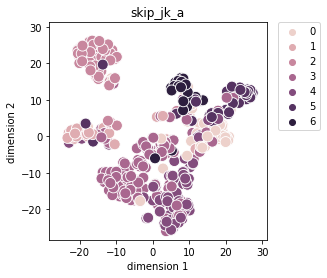

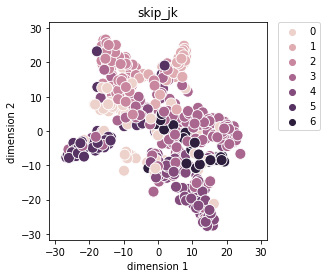

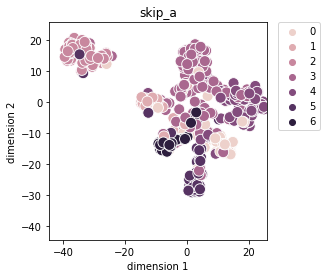

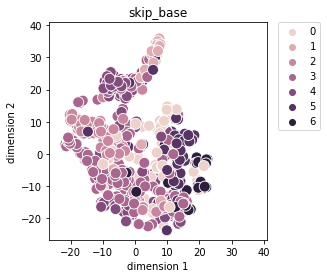

In [ ]:
visualise(skip_feature_dict)

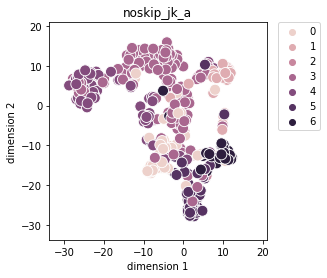

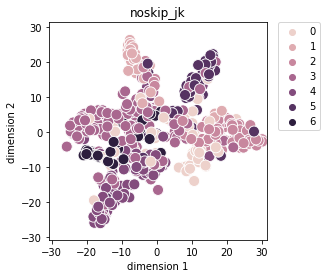

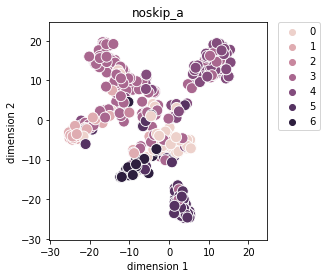

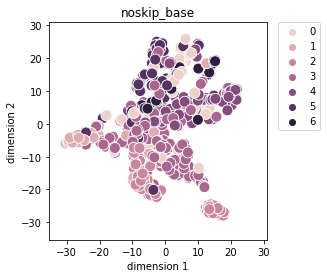

In [ ]:
visualise(noskip_feature_dict)

In [ ]:
def test(model) -> torch.nn.Module:
    """ Trains node classification model and returns the trained model """
    #set device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    #load dataset
    data = dataset.data
    data = data.to(device)
    x = data.x
    edge_index = data.edge_index
    y = data.y

    #update parameters
    params["input_dim"] = dataset.num_features 
    params["output_dim"] = dataset.num_classes

    #get mask
    test_mask = data.test_mask
    
    model.eval()
    outputs = model(x, edge_index)
    pred = torch.argmax(outputs[test_mask], 1)

    acc = torch.sum(torch.eq(y[test_mask], pred)) / y[test_mask].size()[0]

    print('Test accuracy:', acc)
    return 

In [ ]:
test(noskip_jk_a_3_layer)

Test accuracy: tensor(0.7770, device='cuda:0')


In [ ]:
test(noskip_jk_2_layer)

Test accuracy: tensor(0.6800, device='cuda:0')


In [ ]:
test(noskip_a_4_layer)

Test accuracy: tensor(0.7930, device='cuda:0')


In [ ]:
test(noskip_base_3_layer)

Test accuracy: tensor(0.7120, device='cuda:0')


In [ ]:
test(skip_jk_a_3_layer)

Test accuracy: tensor(0.7880, device='cuda:0')


In [ ]:
test(skip_jk_2_layer)

Test accuracy: tensor(0.6800, device='cuda:0')


In [ ]:
test(skip_a_3_layer)

Test accuracy: tensor(0.7710, device='cuda:0')


In [ ]:
test(skip_base_2_layer)

Test accuracy: tensor(0.7390, device='cuda:0')


In [ ]:
def test_dimension_reduction(model: nn.Module) -> pd.DataFrame:
    """
    Returns a pandas DataFrame with 'dimension 1', 'dimension 2', and 'labels' as a column
    """
    model.eval()
    embeddings = model(dataset.data.x, dataset.data.edge_index)[dataset.data.test_mask]
    labels = dataset.data.y[dataset.data.test_mask].detach().cpu()
    n_components = 2
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(embeddings.detach().cpu())
    
    df = pd.DataFrame(columns = ['dimension 1', 'dimension 2', 'labels'])
    df['dimension 1'] = tsne_result[:,0]
    df['dimension 2'] = tsne_result[:,1]
    df['labels'] = labels
    
    return df

In [ ]:
test_skip_feature_dict = {
    "skip_jk_a": test_dimension_reduction(skip_jk_a_3_layer),
    "skip_jk": test_dimension_reduction(skip_jk_2_layer),
    "skip_a": test_dimension_reduction(skip_a_3_layer),
    "skip_base": test_dimension_reduction(skip_base_2_layer),
}

test_noskip_feature_dict = {
    "noskip_jk_a": test_dimension_reduction(noskip_jk_a_3_layer),
    "noskip_jk": test_dimension_reduction(noskip_jk_2_layer),
    "noskip_a": test_dimension_reduction(noskip_a_4_layer),
    "noskip_base": test_dimension_reduction(noskip_base_3_layer),
}

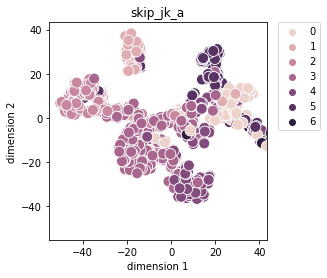

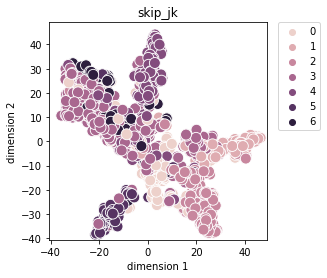

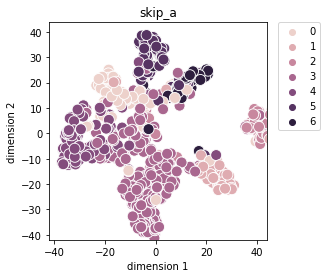

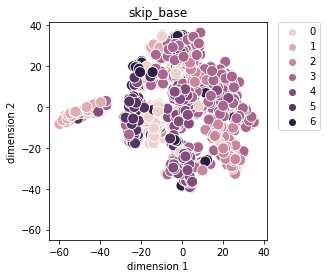

In [ ]:
visualise(test_skip_feature_dict)

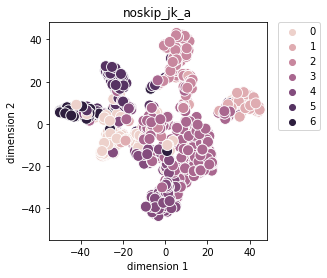

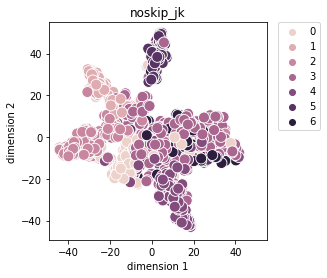

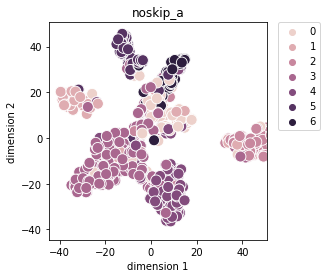

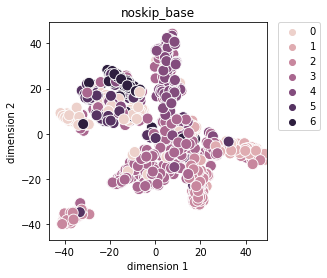

In [ ]:
visualise(test_noskip_feature_dict)